In [1]:
from src import Modeler, Processor, Reader
import pandas as pd
from datetime import datetime
from sklearn import metrics, model_selection, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [2]:
# Using the US Census regions from here: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
south_atlantic_states = [
    10   # Delaware
    , 11 # DC
    , 12 # Florida
    , 13 # Georgia
    , 24 # Maryland
    , 37 # North Carolina
    , 45 # South Carolina
    , 51 # Virginia
    , 54 # West Virginia
]
state_filter = south_atlantic_states

In [3]:
state_dict = {
    'code' : ['10', '11', '12', '13', '24', '37', '45', '51', '54']
    , 'state_name' : ['Delware', 'DC', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
}

state_code_map = pd.DataFrame(data=state_dict)

## Loading data

In [4]:
# Instantiate preprocessor
preprocessor = Processor.PreProcessor(state_filter=state_filter)

In [5]:
preprocessor.load_processed_data()

/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:36: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])
/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:36: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])


In [6]:
# Put data into a df to work with
df = preprocessor.get_current_data()
# Export data to csv so that the data does not have to be recreated each run
df.to_csv('COVID_Analysis_Data.csv',index=False)
# Show data
df.head()

,FIPS_10001,FIPS_10003,FIPS_10005,FIPS_11001,FIPS_12001,FIPS_12003,FIPS_12005,FIPS_12007,FIPS_12009,FIPS_12011,...,is_metro,Series_Complete_Pop_Pct_UR_Equity,cases,deaths,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,25.142857,0.142857,3.428571,3.857143,3.428571,0.285714,0.285714,0.285714
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,26.714286,0.285714,4.714286,3.428571,3.857143,0.285714,0.285714,0.285714
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,27.857143,0.285714,6.142857,4.714286,3.428571,0.0,0.285714,0.285714
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,22.857143,0.428571,8.714286,6.142857,4.714286,0.0,0.0,0.285714
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,26.0,0.571429,14.428571,8.714286,6.142857,0.142857,0.0,0.0


In [7]:
# Load data
df = pd.read_csv("COVID_Analysis_Data.csv")

In [8]:
df.shape

(289884, 704)

## Split into train and test

In [9]:
modeler = Modeler.Modeler()

In [23]:
# Split data into training and test dataset:
train_end_date = '2021-06-14'
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(df, train_end_date)

## Plotting functions

In [24]:
def plot_predictions(y_test, y_pred):
    plt.scatter(y_test, y_pred, color='none', edgecolor='b')
    xymin = min(np.min(y_test), np.min(y_pred))
    xymax = max(np.max(y_test), np.max(y_pred))
    plt.plot([xymin, xymax],[xymin, xymax], color="r", linestyle="--")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actuals vs Predicted', fontsize=16)
    plt.show()
    
def plot_residuals(X_test, residuals):
    plt.figure(figsize=(18, 6))
    sns.scatterplot(x=df['date'], y=residuals, color='none', edgecolor='r')
    plt.title('Residuals', fontsize=16)
    plt.show()

## Modeling functions

In [39]:
def run_full_pipeline(model, X_train, y_train, X_test, y_test):
    # Cross validate and report scores:
    scores = modeler.cv_model(model, X_train, y_train)
    print('Cross-Validation Scores:')
    for k, v in scores.items():
        print(f'\t{k}: {round(v[0],2)} +/- {round(v[1],2)}')
    # Test data
    y_pred, rmse, r2 = modeler.test_model(model, X_train, y_train, X_test, y_test)
    residuals = (y_test - y_pred)
    # Plots
    plot_predictions(y_test, y_pred)
    plot_residuals(X_test, residuals)
    return y_pred, rmse, r2

## Linear Regression

In [26]:
lm_model = LinearRegression()

### All Data - Cases

Cross-Validation Scores:
Negative RMSE: -6493318168.196895 +/- 10203491044.115135
r2: -7.405176579318043e+16 +/- 1.4214917572200078e+17
Explained Variance: -5.522193490980344e+16 +/- 1.0459293401792045e+17
Model testing scores:
RMSE: 32.52
R^2 Score: 0.90


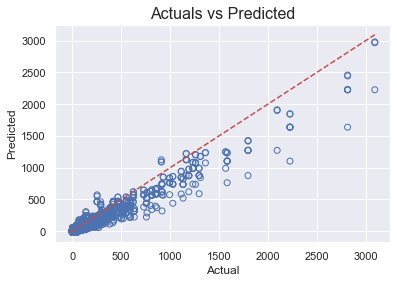

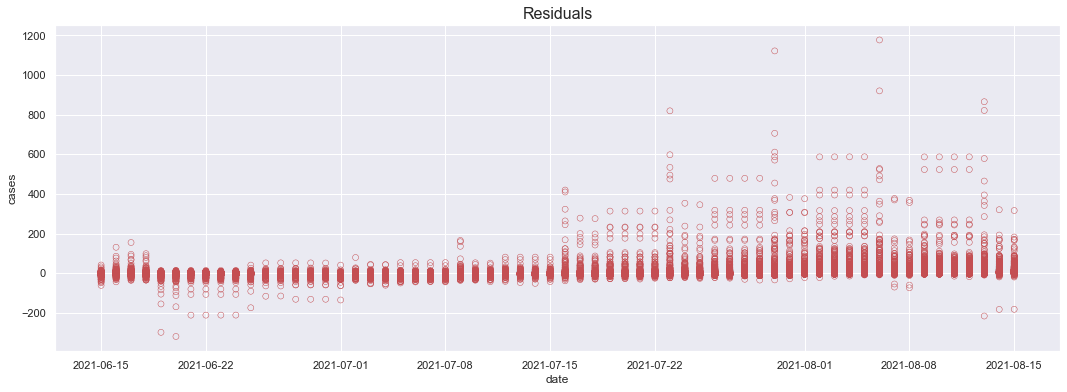

In [29]:
cases_residuals, cases_rmse, cases_r2 = run_full_pipeline(lm_model, X_train, y_train_cases, X_test, y_test_cases)

In [30]:
# What happens if we remove these outliers?
# Does the model fit improve significantly?
fips_df = pd.DataFrame(X_test[cases_residuals > 250][[c for c in df.columns if c[:4] == 'FIPS']].sum()).rename(columns={0:'count'})
fips_df[fips_df['count'] > 0]

,count
FIPS_12009,16.0
FIPS_12011,39.0
FIPS_12021,2.0
FIPS_12031,32.0
FIPS_12033,4.0
FIPS_12057,23.0
FIPS_12069,9.0
FIPS_12071,11.0
FIPS_12073,2.0
FIPS_12081,2.0


### All Data - deaths

Cross-Validation Scores:
Negative RMSE: -119245815.58815661 +/- 184335442.2708106
r2: -7.229180275954136e+16 +/- 1.4122685476290022e+17
Explained Variance: -5.353864736017066e+16 +/- 1.040655825710685e+17
Model testing scores:
RMSE: 0.50
R^2 Score: -3.74


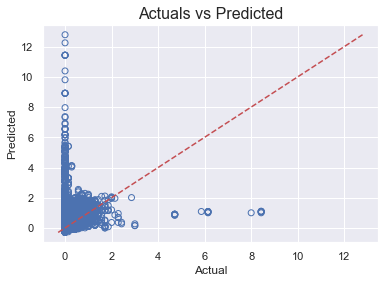

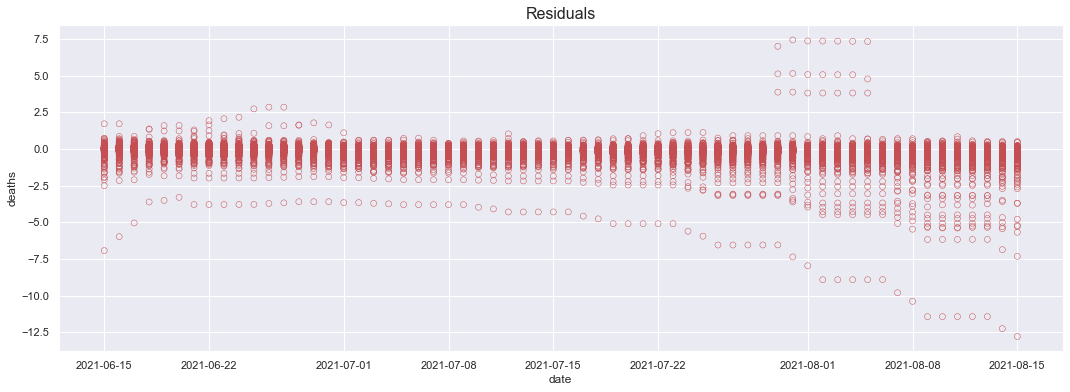

In [16]:
deaths_residuals, deaths_rmse, deaths_r2 = run_full_pipeline(lm_model, X_train, y_train_deaths, X_test, y_test_deaths)

In [17]:
# What happens if we remove these outliers?
# Does the model fit improve significantly?
fips_df = pd.DataFrame(X_test[deaths_residuals > 1000][[c for c in df.columns if c[:4] == 'FIPS']].sum()).rename(columns={0:'count'})
fips_df[fips_df['count'] > 0]

,count


### No FIPS Columns - Cases

In [33]:
no_fips_df = df.drop([c for c in df.columns if c[:4] == 'FIPS'], axis=1)

In [34]:
# Split data into training and test dataset:
train_end_date = '2021-06-14'
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(no_fips_df, train_end_date)

Cross-Validation Scores:
Negative RMSE: -21.339702427589295 +/- 9.77307963921962
r2: 0.8964990220282599 +/- 0.03322144730892528
Explained Variance: 0.8974936069894437 +/- 0.03310735139273095
Model testing scores:
RMSE: 34.65
R^2 Score: 0.89


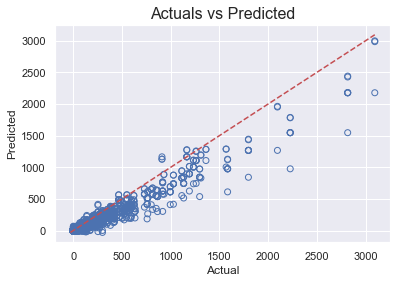

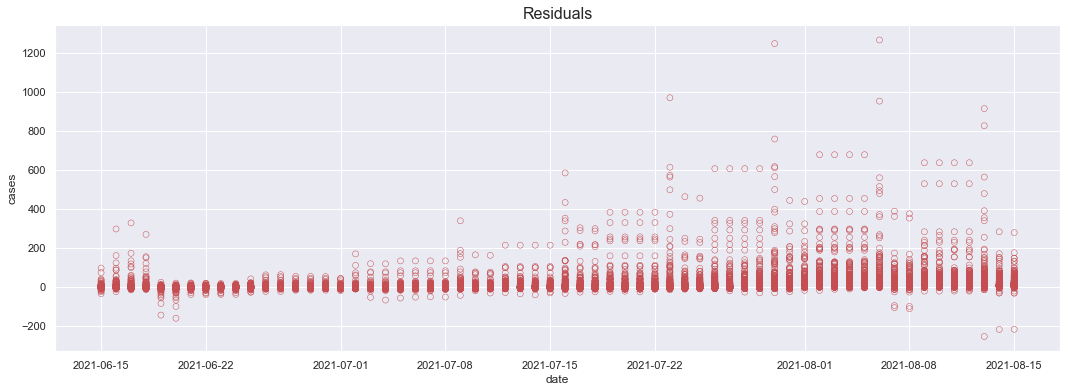

In [35]:
cases_residuals, cases_rmse, cases_r2 = run_full_pipeline(lm_model, X_train, y_train_cases, X_test, y_test_cases)

### No FIPS - deaths

Cross-Validation Scores:
Negative RMSE: -0.5783587867293919 +/- 0.17836714785294547
r2: 0.6331871172774408 +/- 0.15940462127436913
Explained Variance: 0.6430657044740048 +/- 0.14945644350376255
Model testing scores:
RMSE: 0.43
R^2 Score: -2.58


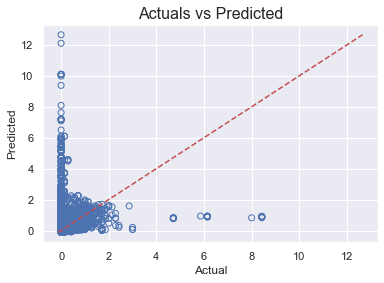

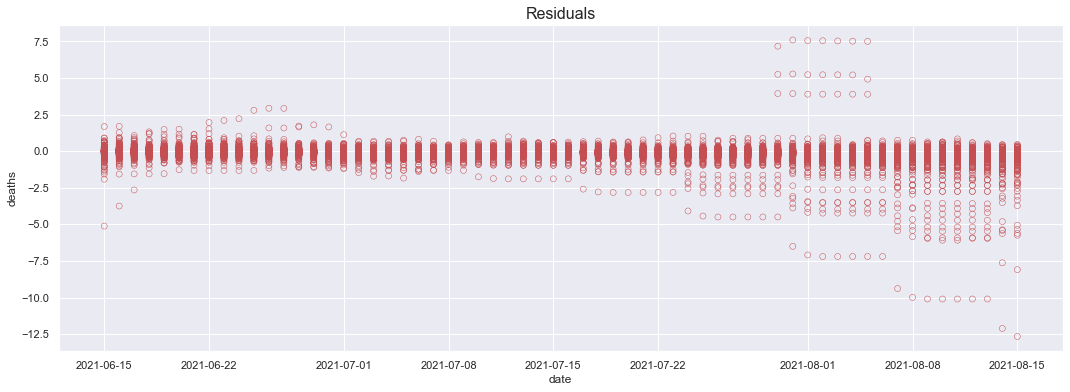

In [37]:
deaths_residuals, deaths_rmse, deaths_r2 = run_full_pipeline(lm_model, X_train, y_train_deaths, X_test, y_test_deaths)

### Excluding Florida - cases

In [40]:
data_no_fl = df[df['STATE_12'] != 1].drop(['STATE_12'], axis=1)
data_no_fl = data_no_fl.drop([c for c in data_no_fl.columns if c[:7] == 'FIPS_12'], axis=1)

In [41]:
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(data_no_fl, '2021-06-14')

Cross-Validation Scores:
	Negative RMSE: -4878277101.61 +/- 3740491384.49
	r2: -1.6230206894134272e+16 +/- 1.920827286957771e+16
	Explained Variance: -1.5664277966151206e+16 +/- 1.9270726270960536e+16
Model testing scores:
RMSE: 13.09
R^2 Score: 0.79


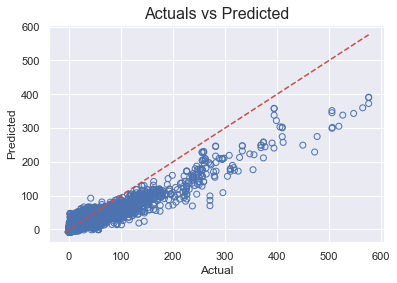

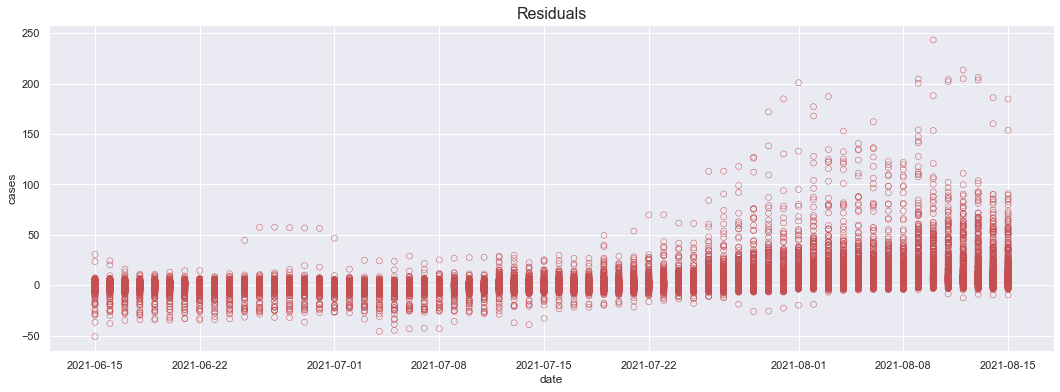

In [42]:
cases_residuals, cases_rmse, cases_r2 = run_full_pipeline(lm_model, X_train, y_train_cases, X_test, y_test_cases)

### Excluding Florida - deaths

Cross-Validation Scores:
	Negative RMSE: -85360017.77 +/- 92288286.98
	r2: -3.1383432863563892e+16 +/- 5.663776226509974e+16
	Explained Variance: -2.7482185963238004e+16 +/- 4.931001234529946e+16
Model testing scores:
RMSE: 0.29
R^2 Score: -0.45


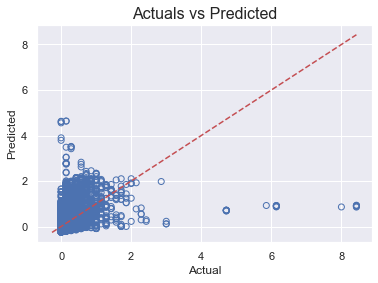

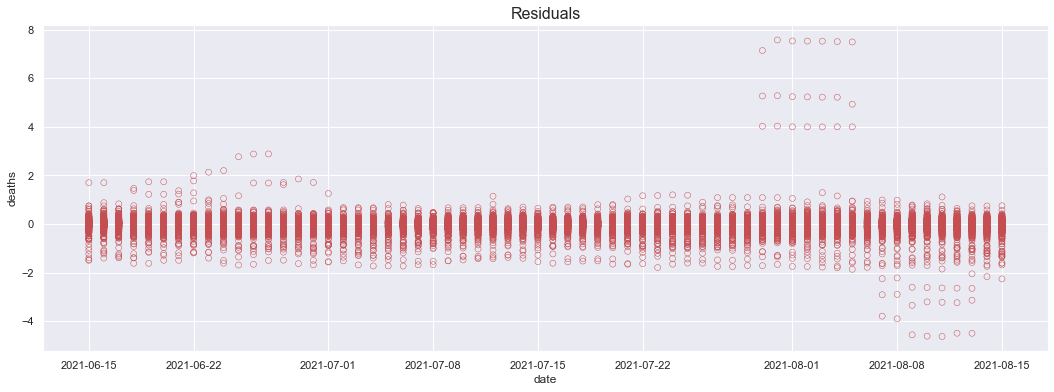

In [43]:
deaths_residuals, deaths_rmse, deaths_r2 = run_full_pipeline(lm_model, X_train, y_train_deaths, X_test, y_test_deaths)

In [ ]:
# Test out combining all of the data for a single state and seeing how far off cases/deaths predictions were?


# Decision Tree

In [ ]:
# Testing on cases

model_dt = DecisionTreeRegressor()

scores_dt = model_selection.cross_validate(model_dt, X_train, y_train_cases, cv=5, scoring='neg_root_mean_squared_error')
    
## Training model on entire training dataset
model_dt.fit(X_train, y_train_cases)

y_preds_dt = model_dt.predict(X_test)

print()
# The mean square error
rmse_dt = np.sqrt(np.mean((y_preds_dt - y_test_cases) ** 2))



## KNN Regressor

In [ ]:
# Testing on cases

model_knn = KNeighborsRegressor()

scores_knn = model_selection.cross_validate(model_knn, X_train, y_train_cases, cv=5, scoring='neg_root_mean_squared_error')
    
## Training model on entire training dataset
model_knn.fit(X_train, y_train_cases)

y_preds_knn = model_knn.predict(X_test)

print()
# The mean square error
rmse_knn= np.sqrt(np.mean((y_preds_knn - y_test_cases) ** 2))



In [ ]:
print('Decision tree RMSE:', rmse_dt)
print('Linear Regression RMSE:', rmse)
print('KNN Regression RMSE:', rmse_knn)

In [ ]:
# Checking out how the prediction looked vs the model
county_mask = X_test['FIPS_12005'] == 1
county_mask_train = X_train['FIPS_12005'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds[county_mask], color='none', edgecolor='g')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_knn[county_mask], color='none', edgecolor='c')
plt.scatter(x=X_train[county_mask_train]['days_from_start'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_test_cases[county_mask], color='none', edgecolor='b');

In [ ]:
# Checking out how the prediction looked vs the model (Alexandria, VA FIPS 51510)
county_mask = X_test['FIPS_51510'] == 1
county_mask_train = X_train['FIPS_51510'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds[county_mask], color='none', edgecolor='g')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_knn[county_mask], color='none', edgecolor='c')
plt.scatter(x=X_train[county_mask_train]['days_from_start'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_test_cases[county_mask], color='none', edgecolor='b');

In [ ]:
# Checking out how the prediction looked vs the model (Atlanta, GA Fulton county 13121)
county_mask = X_test['FIPS_13121'] == 1
county_mask_train = X_train['FIPS_13121'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds[county_mask], color='none', edgecolor='g')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_knn[county_mask], color='none', edgecolor='c')
plt.scatter(x=X_train[county_mask_train]['days_from_start'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_test_cases[county_mask], color='none', edgecolor='b');

In [ ]:
y_train_cases[county_mask_train].values[-1]

In [ ]:
y_preds_dt[county_mask]